# **EXPLORATORY DATA ANALYSIS ON TTC STATIONS**
This is the third part of my TTC Subway Delay project.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import textwrap
import calendar
import requests
import json
import io
import geopandas as gpd
from shapely.geometry import shape, Point

In [3]:
df_master = pd.read_excel('Excel Files/df_master.xlsx')
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,time_period,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,early_morning,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,early_morning,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,early_morning,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214456,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,evening,Miscellaneous Other,Undefined
214457,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,evening,Disorderly Patron,Passenger Related
214458,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,evening,Robbery,Passenger Related
214459,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,evening,Miscellaneous Other,Undefined


# Map Data Extraction and Cleaning

Here, we'll conduct EDA on the stations and check for any patterns or trends. We'll be importing map data from an arcgis database accessible through a url, so we can plot our data in a map that will look like the TTC subway. We can also do an EDA using the typical charts such as bar or line, but I want to make things visually interesting for the spatial data we have for this part of our EDA.

In [4]:
url = "https://gis.toronto.ca/arcgis/rest/services/cot_geospatial7/FeatureServer/8/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses
geojson_data = json.loads(response.text)

# Convert the GeoJSON data to a GeoDataFrame
ttc_map = gpd.GeoDataFrame.from_features(geojson_data["features"])
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_KISS_RIDE,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2
0,POINT (-79.39835 43.70534),11272589,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None
1,POINT (-79.39712 43.69785),7273830,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None
2,POINT (-79.39298 43.68811),14076438,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None
3,POINT (-79.39079 43.68229),8681089,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001,...,No,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None
4,POINT (-79.38875 43.67694),788874,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001,...,No,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,POINT (-79.41309 43.76901),14076455,5152,Yonge St,5152 Yonge St,None,North York,Toronto,None,115001,...,No,Train Platform to Mezzanine,No,"97,B,C Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/North_York_C...,None,None
69,POINT (-79.41236 43.7617),13967653,20,Sheppard Ave W,20 Sheppard Ave W,M2N 7H9,North York,Toronto,None,115001,...,No,Train Platform to Mezzanine and Bus Platform,Yes,"97,B,C Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard-Yon...,None,None
70,POINT (-79.40636 43.7449),12036646,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001,...,No,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None
71,POINT (-79.40193 43.72535),7762894,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None


Looking at the above extracted geographic data set from arcgis, we can see two (2) concerns:
1. There's no explicit column for the station name. We can, however, extract this from the 'PT_WEBSITE' column; and
2. Two (2) stations are missing from the data set: Vaughan Metropolitan Centre and Highway 407. We'll try to append these two to the data set above. The important features we need are 'LONGITUDE', 'LATITUDE', and the station name.

Let's work on extracting the station name first.

In [5]:
ttc_map['station_clean'] = ttc_map['PT_WEBSITE'].str.extract(r'http://www.ttc.ca/Subway/Stations/([^/]+)')
ttc_map['station_clean'] = ttc_map['station_clean'].str.replace('_', ' ')
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.39835 43.70534),11272589,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39712 43.69785),7273830,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39298 43.68811),14076438,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St Clair
3,POINT (-79.39079 43.68229),8681089,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38875 43.67694),788874,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,POINT (-79.41309 43.76901),14076455,5152,Yonge St,5152 Yonge St,None,North York,Toronto,None,115001,...,Train Platform to Mezzanine,No,"97,B,C Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/North_York_C...,None,None,North York Centre
69,POINT (-79.41236 43.7617),13967653,20,Sheppard Ave W,20 Sheppard Ave W,M2N 7H9,North York,Toronto,None,115001,...,Train Platform to Mezzanine and Bus Platform,Yes,"97,B,C Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard-Yon...,None,None,Sheppard-Yonge
70,POINT (-79.40636 43.7449),12036646,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193 43.72535),7762894,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence


Now that that's done, let's work on adding the rows for the two (2) missing stations.

In [6]:
new_rows = [{'station_clean': 'Vaughan Metropolitan Centre',
             'LONGITUDE': '-79.5275',
             'LATITUDE': '43.794167'},
             {'station_clean': 'Highway 407',
             'LONGITUDE': '-79.523056',
             'LATITUDE': '43.783333'}]

for row in new_rows:
    for col in ttc_map.columns:
        row.setdefault(col, np.nan)

# Append new rows
ttc_map = pd.concat([ttc_map, pd.DataFrame(new_rows)], ignore_index=True)
ttc_map

/var/folders/0w/36fvl5tn3b71hvbn68mbwpkm0000gn/T/ipykernel_74724/3714397909.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ttc_map = pd.concat([ttc_map, pd.DataFrame(new_rows)], ignore_index=True)


,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.39835 43.70534),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39712 43.69785),7273830.0,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39298 43.68811),14076438.0,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St Clair
3,POINT (-79.39079 43.68229),8681089.0,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001.0,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38875 43.67694),788874.0,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001.0,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,POINT (-79.40636 43.7449),12036646.0,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001.0,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193 43.72535),7762894.0,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence
72,POINT (-79.46265 43.74993),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West
73,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre


Afterwards, we'll have to ensure that the 'geometry' attribute captures the longitude and latitude data, and is in the correct data type, geospatial.

In [7]:
ttc_map['geometry'] = gpd.points_from_xy(ttc_map['LONGITUDE'], ttc_map['LATITUDE'])
ttc_map = gpd.GeoDataFrame(ttc_map, geometry = 'geometry')
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.39836 43.70535),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39713 43.69786),7273830.0,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39299 43.68812),14076438.0,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St Clair
3,POINT (-79.39079 43.6823),8681089.0,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001.0,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38875 43.67694),788874.0,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001.0,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,POINT (-79.40637 43.74491),12036646.0,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001.0,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193 43.72535),7762894.0,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence
72,POINT (-79.46265 43.74993),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West
73,POINT (-79.5275 43.79417),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre


In [8]:
ttc_map.dtypes

geometry            geometry
ADDRESS_POINT_ID     float64
ADDRESS_NUMBER        object
LINEAR_NAME_FULL      object
ADDRESS_FULL          object
POSTAL_CODE           object
MUNICIPALITY          object
CITY                  object
PLACE_NAME            object
GENERAL_USE_CODE     float64
CENTRELINE_ID        float64
LO_NUM               float64
LO_NUM_SUF            object
HI_NUM                object
HI_NUM_SUF            object
LINEAR_NAME_ID       float64
X                    float64
Y                    float64
LONGITUDE             object
LATITUDE              object
MAINT_STAGE           object
OBJECTID             float64
PT_ID                float64
PT_TYPE               object
PT_NAME               object
PT_CONN_ROUTE         object
PT_PUB_PARK           object
PT_KISS_RIDE          object
PT_ESCALATOR          object
PT_ELEVATOR           object
PT_TRANSF_REQ         object
PT_PUB_WASH           object
PT_PHONE              object
PT_OTHER_TRAN         object
PT_WEBSITE    

Let's plot it!

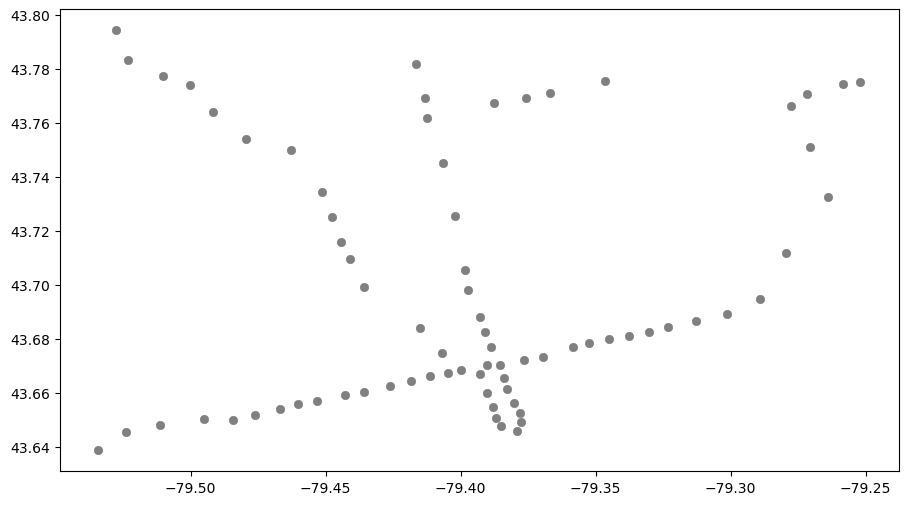

In [9]:
fig, ax = plt.subplots(figsize = (12,6))
ttc_map.plot(ax = ax,
             color = 'gray',
             linewidth = 0.5)
plt.show()

# Functions and Loops

We'll define some functions here that will speed up our EDA.

# Station Delay Duration and Occurrence

We'll create a summary table for delay occurrence and duration per station.

In [10]:
station = df_master.groupby('station_clean').agg(
    total_occurrence = ('Min Delay', 'count'),
    delay_duration = ('Min Delay', 'sum')).reset_index()
station

,station_clean,total_occurrence,delay_duration
0,Bathurst,2140,4377
1,Bay,1596,4253
2,Bayview,912,3200
3,Bessarion,532,1837
4,Bloor-Yonge,21332,28188
...,...,...,...
70,Wilson,5429,14621
71,Woodbine,2054,5169
72,York Mills,3105,8503
73,York University,477,1274


Then we'll merge it with the ttc_map data set.

In [11]:
merged_data = ttc_map.merge(station, left_on = 'station_clean', right_on = 'station_clean', how = 'left')
merged_data

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean,total_occurrence,delay_duration
0,POINT (-79.39836 43.70535),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton,5978,17994
1,POINT (-79.39713 43.69786),7273830.0,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001.0,...,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville,3728,11014
2,POINT (-79.39299 43.68812),14076438.0,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001.0,...,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St Clair,2860,8246
3,POINT (-79.39079 43.6823),8681089.0,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001.0,...,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill,1467,5623
4,POINT (-79.38875 43.67694),788874.0,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001.0,...,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale,2104,6909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,POINT (-79.40637 43.74491),12036646.0,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001.0,...,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills,3105,8503
71,POINT (-79.40193 43.72535),7762894.0,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001.0,...,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence,3110,8375
72,POINT (-79.46265 43.74993),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West,4676,14287
73,POINT (-79.5275 43.79417),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre,4177,12356


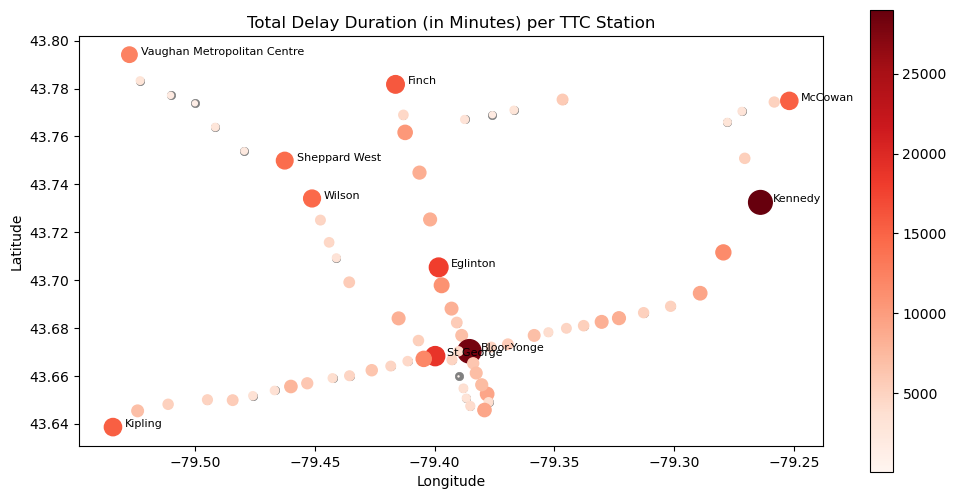

In [12]:
fig, ax = plt.subplots(figsize = (12, 6))
ttc_map.plot(ax = ax, 
             color = 'gray', 
             linewidth = 0.5)
merged_data.plot(ax = ax, 
                 column = 'delay_duration', 
                 cmap = 'Reds', 
                 legend = True, 
                 markersize = merged_data['delay_duration'] / 100)
plt.title('Total Delay Duration (in Minutes) per TTC Station')

# Annotate the top 10 stations
top_10_stations = merged_data.sort_values(by = ['delay_duration'], ascending = False).head(10)
for index, row in top_10_stations.iterrows():
    ax.annotate(row['station_clean'], 
                (row['geometry'].x, 
                 row['geometry'].y),
                xytext = (row['geometry'].x + 0.005, row['geometry'].y + 0.0),
                fontsize = 8, 
                color = 'black')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Findings: Station Delay Duration and Occurrence

# Stations and Delay Causes